In [100]:
import pandas as pd

# Load the dataset
df = pd.read_excel("P585 Churn.xlsx")

# Display the first 5 rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Unnamed: 0,state,area.code,account.length,voice.plan,voice.messages,intl.plan,intl.mins,intl.calls,intl.charge,...,day.calls,day.charge,eve.mins,eve.calls,eve.charge,night.mins,night.calls,night.charge,customer.calls,churn
0,1,KS,415,128,yes,25,no,10.0,3,2.70,...,110,45.07,197.4,99,16.78,244.7,91,11.01,1,no
1,2,OH,415,107,yes,26,no,13.7,3,3.70,...,123,27.47,195.5,103,16.62,254.4,103,11.45,1,no
2,3,NJ,415,137,no,0,no,12.2,5,3.29,...,114,41.38,121.2,110,10.30,162.6,104,7.32,0,no
3,4,OH,415,84,no,0,yes,6.6,7,1.78,...,71,50.9,61.9,88,5.26,196.9,89,8.86,2,no
4,5,OK,415,75,no,0,yes,10.1,3,2.73,...,113,28.34,148.3,122,12.61,186.9,121,8.41,3,no


In [101]:
print(df.columns.tolist())

['Unnamed: 0', 'state', 'area.code', 'account.length', 'voice.plan', 'voice.messages', 'intl.plan', 'intl.mins', 'intl.calls', 'intl.charge', 'day.mins', 'day.calls', 'day.charge', 'eve.mins', 'eve.calls', 'eve.charge', 'night.mins', 'night.calls', 'night.charge', 'customer.calls', 'churn']


In [102]:
# Print the shape and info of the DataFrame
print(f"\nDataset Dimensions (Rows, Columns): {df.shape}\n")
print("Column Data Types and Non-Null Counts:")
df.info()


Dataset Dimensions (Rows, Columns): (5000, 21)

Column Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5000 non-null   int64  
 1   state           5000 non-null   object 
 2   area.code       5000 non-null   int64  
 3   account.length  5000 non-null   int64  
 4   voice.plan      5000 non-null   object 
 5   voice.messages  5000 non-null   int64  
 6   intl.plan       5000 non-null   object 
 7   intl.mins       5000 non-null   float64
 8   intl.calls      5000 non-null   int64  
 9   intl.charge     5000 non-null   float64
 10  day.mins        5000 non-null   float64
 11  day.calls       5000 non-null   int64  
 12  day.charge      5000 non-null   object 
 13  eve.mins        5000 non-null   object 
 14  eve.calls       5000 non-null   int64  
 15  eve.charge      5000 non-null   flo

In [103]:
# ---------------------------------------------------------
# 🔍 CHECKING FOR DUPLICATE ROWS
# ---------------------------------------------------------

# 1️⃣ Count total duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Total Duplicate Rows: {duplicate_count}")

# 2️⃣ Display the duplicate rows (if any)
if duplicate_count > 0:
    print("\nDuplicate Rows:")
    display(df[df.duplicated()])
else:
    print("\n✅ No duplicate rows found.")

Total Duplicate Rows: 0

✅ No duplicate rows found.


In [104]:
# Check for any missing values in the entire DataFrame
print(f"Any missing values? {df.isna().values.any()}")

# Get a count of missing values per column
print("\nCount of NaN values in each column:")
print(df.isna().sum())

Any missing values? False

Count of NaN values in each column:
Unnamed: 0        0
state             0
area.code         0
account.length    0
voice.plan        0
voice.messages    0
intl.plan         0
intl.mins         0
intl.calls        0
intl.charge       0
day.mins          0
day.calls         0
day.charge        0
eve.mins          0
eve.calls         0
eve.charge        0
night.mins        0
night.calls       0
night.charge      0
customer.calls    0
churn             0
dtype: int64


In [105]:
import numpy as np

# Replace all string "Nan" / "nan" / "NaN" (case-insensitive) with actual np.nan
df.replace(to_replace=['Nan', 'nan', 'NaN', 'NAN'], value=np.nan, inplace=True)

# Verify replacement worked
print("--- After Replacing 'Nan' with np.nan ---")
print(df.isnull().sum())

--- After Replacing 'Nan' with np.nan ---
Unnamed: 0         0
state              0
area.code          0
account.length     0
voice.plan         0
voice.messages     0
intl.plan          0
intl.mins          0
intl.calls         0
intl.charge        0
day.mins           0
day.calls          0
day.charge         7
eve.mins          24
eve.calls          0
eve.charge         0
night.mins         0
night.calls        0
night.charge       0
customer.calls     0
churn              0
dtype: int64


/tmp/ipython-input-1949711140.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace=['Nan', 'nan', 'NaN', 'NAN'], value=np.nan, inplace=True)


In [106]:
# Impute with median (more robust against outliers)
df['day.charge'].fillna(df['day.charge'].median(), inplace=True)
df['eve.mins'].fillna(df['eve.mins'].median(), inplace=True)

# Verify that no missing values remain
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
Unnamed: 0        0
state             0
area.code         0
account.length    0
voice.plan        0
voice.messages    0
intl.plan         0
intl.mins         0
intl.calls        0
intl.charge       0
day.mins          0
day.calls         0
day.charge        0
eve.mins          0
eve.calls         0
eve.charge        0
night.mins        0
night.calls       0
night.charge      0
customer.calls    0
churn             0
dtype: int64


/tmp/ipython-input-3453194760.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['day.charge'].fillna(df['day.charge'].median(), inplace=True)
/tmp/ipython-input-3453194760.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [107]:
# Get descriptive statistics for numerical columns
print("Descriptive Statistics for Numerical Features:")
print(df.describe())

Descriptive Statistics for Numerical Features:
        Unnamed: 0  area.code  account.length  voice.messages    intl.mins  \
count  5000.000000     5000.0      5000.00000     5000.000000  5000.000000   
mean   2500.500000      415.0       100.25860        7.755200    10.261780   
std    1443.520003        0.0        39.69456       13.546393     2.761396   
min       1.000000      415.0         1.00000        0.000000     0.000000   
25%    1250.750000      415.0        73.00000        0.000000     8.500000   
50%    2500.500000      415.0       100.00000        0.000000    10.300000   
75%    3750.250000      415.0       127.00000       17.000000    12.000000   
max    5000.000000      415.0       243.00000       52.000000    20.000000   

        intl.calls  intl.charge     day.mins    day.calls   day.charge  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      4.435200     2.771196   180.288900   100.029400    30.653454   
std       2.456788     0.745

Churn Counts:
churn
no     4293
yes     707
Name: count, dtype: int64

Churn Percentage:
churn
no     85.86
yes    14.14
Name: proportion, dtype: float64


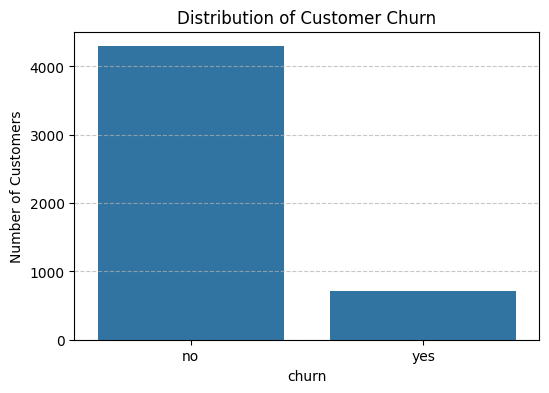

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the counts of 'yes' and 'no'
churn_counts = df['churn'].value_counts()
print("Churn Counts:")
print(churn_counts)

# Get the percentage of 'yes' and 'no'
churn_percentage = df['churn'].value_counts(normalize=True) * 100
print("\nChurn Percentage:")
print(churn_percentage)

# Create a simple plot to visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df, order=['no', 'yes'])
plt.title('Distribution of Customer Churn')
plt.xlabel('churn')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# save the plot as a file
plt.savefig('churn_distribution.png')

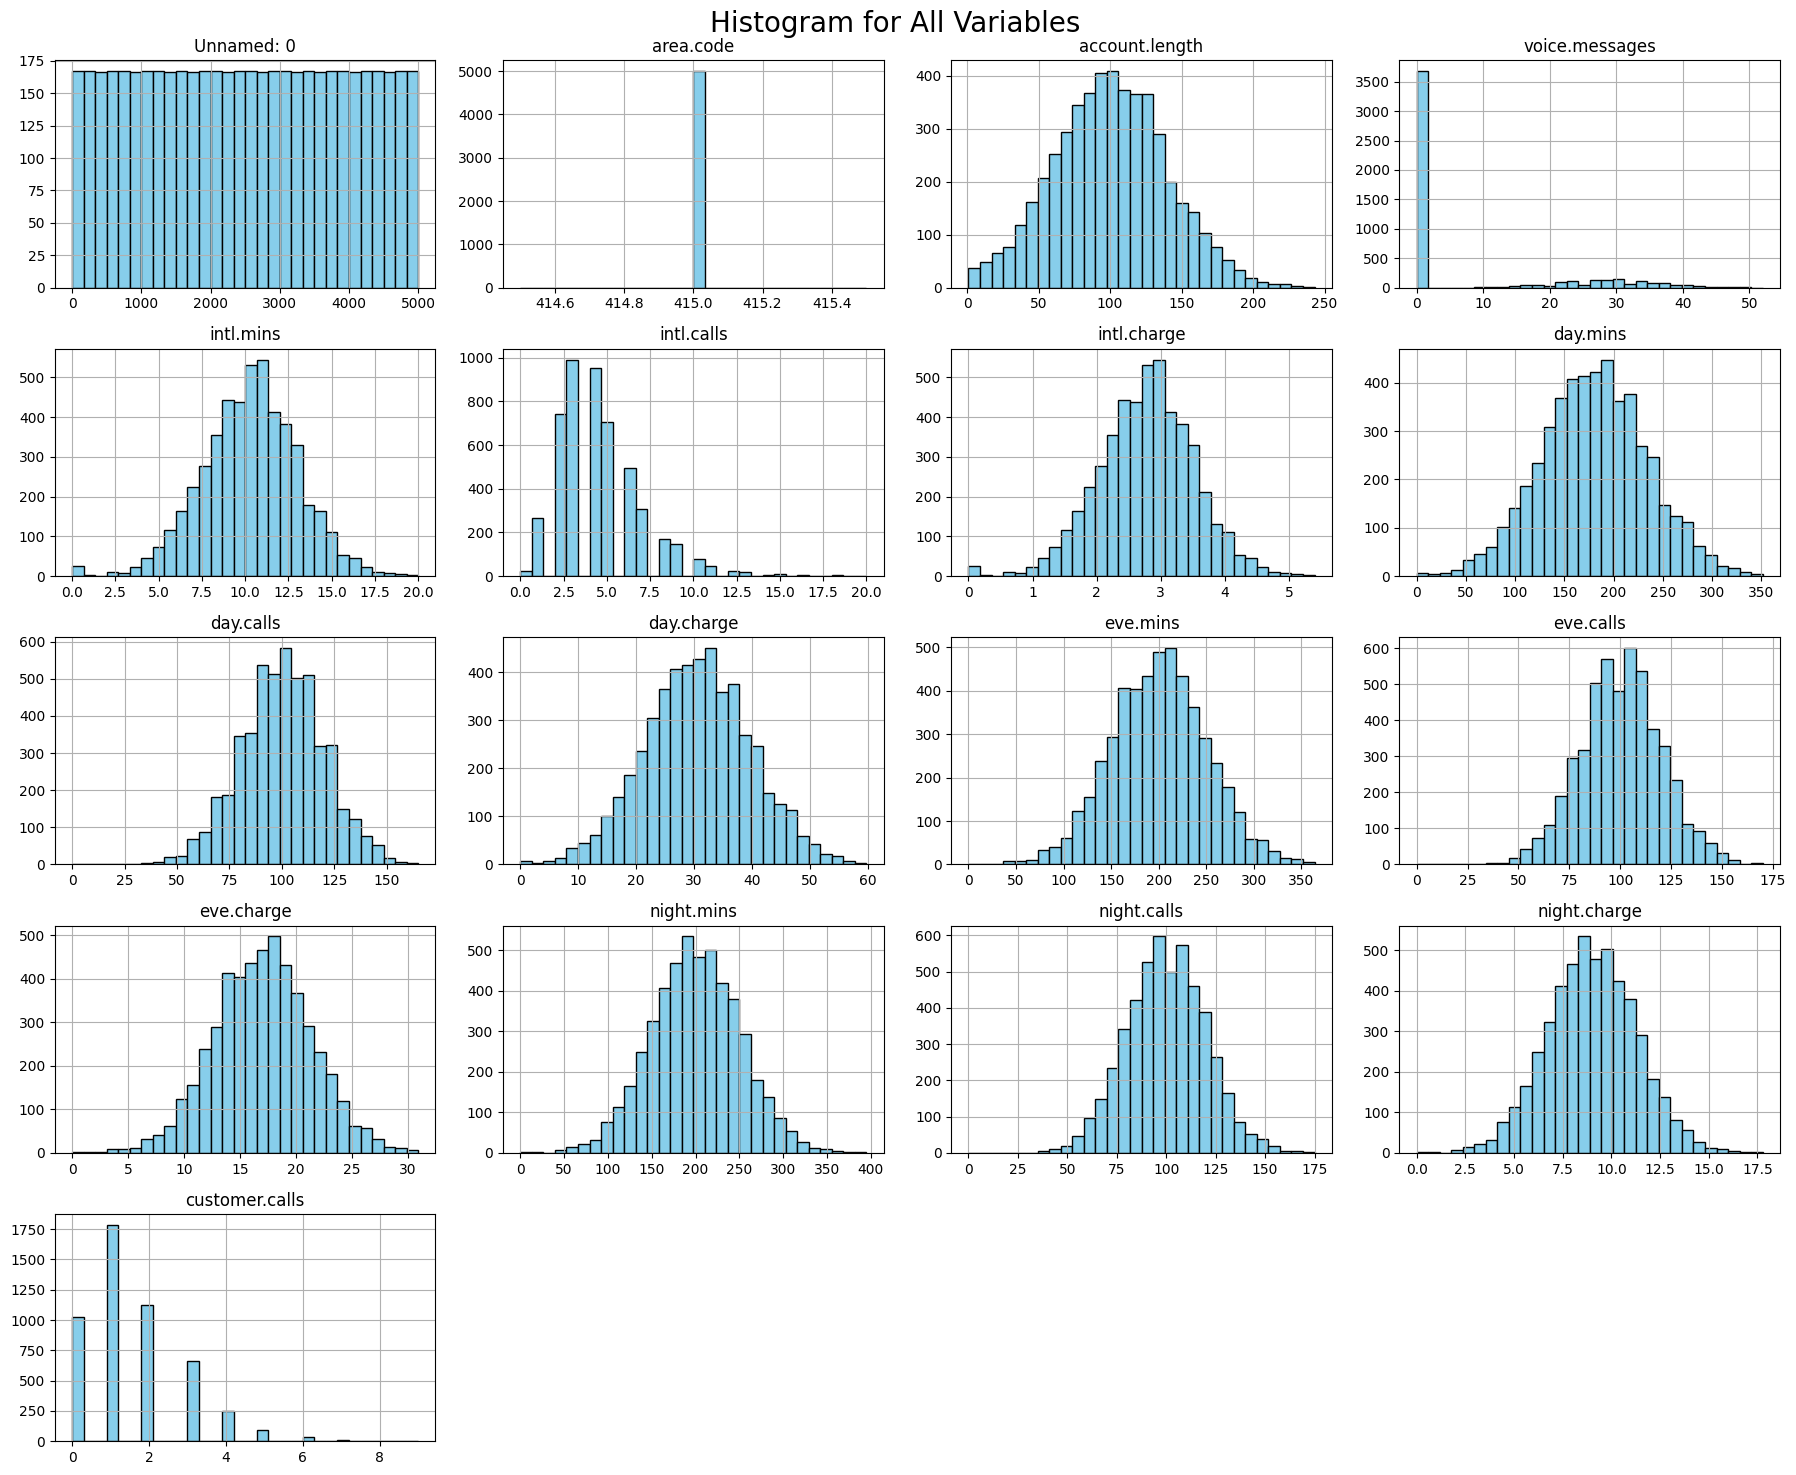

In [109]:
df.hist(figsize=(18, 15), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histogram for All Variables", fontsize=20)
plt.tight_layout()
plt.show()

## \. Representative Sampling

The goal of this step in EDA isn't to visualize every single feature, but to understand the **types of distributions** present in the data. How ever I've histogram for all features,The four columns were chosen to be a good sample of the different kinds of numerical data we have:

  * `account.length`: Represents general customer information (tenure).
  * `total.day.minutes`: Represents a primary, high-usage metric that turned out to be normally distributed (bell-shaped).
  * `number.vmail.messages`: Represents usage of an optional feature, which is heavily skewed with many customers having zero messages.
  * `total.intl.calls`: Represents another usage metric that has a different, slightly skewed distribution.

By looking at these four, we get a good feel for the overall characteristics of our numerical data without having to create 15 separate plots.

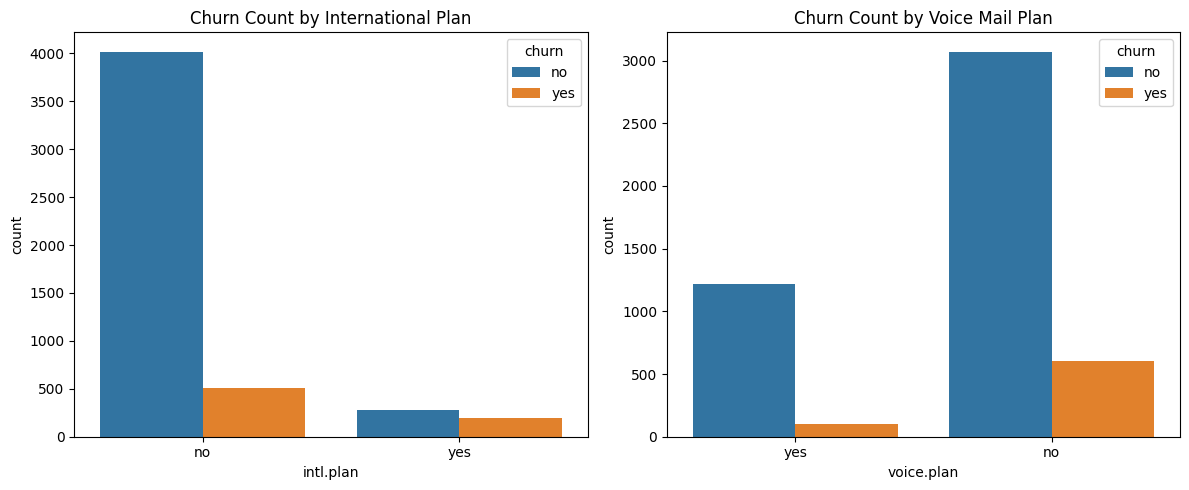

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot relationship between categorical features and churn
plt.figure(figsize=(12, 5))

# Subplot 1: International Plan vs. Churn
plt.subplot(1, 2, 1)
sns.countplot(x='intl.plan', hue='churn', data=df)
plt.title('Churn Count by International Plan')

# Subplot 2: Voice Mail Plan vs. Churn
plt.subplot(1, 2, 2)
sns.countplot(x='voice.plan', hue='churn', data=df)
plt.title('Churn Count by Voice Mail Plan')

plt.tight_layout()
plt.savefig('categorical_churn_relation.png')

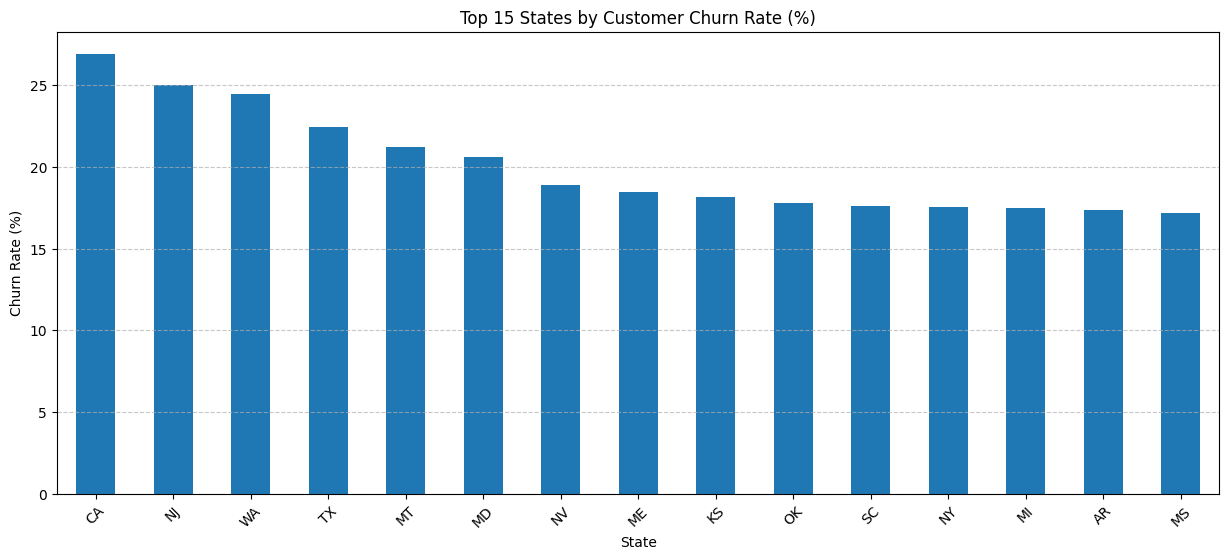

In [111]:
# Calculate churn rate by state
state_churn_rate = df.groupby('state')['churn'].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)

# Plot the top 15 states with the highest churn rates
plt.figure(figsize=(15, 6))
state_churn_rate.head(15).plot(kind='bar')
plt.title('Top 15 States by Customer Churn Rate (%)')
plt.xlabel('State')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('state_churn_rate.png')

  * **International Plan is a huge indicator of churn.** The first chart clearly shows that customers with an international plan churn at a much higher rate than those without. This is a very strong predictive feature.
  * **Voice Mail Plan:** Customers *without* a voice mail plan seem to churn slightly more often than those with one, but the effect is not as dramatic as the international plan.
  * **State-Level Churn:** The churn rate varies significantly by state. New Jersey, California, and Texas appear to have the highest churn rates among the states in this dataset.

-----

### Feature Selection

Based on the exploratory data analysis and correlation analysis, we can consider removing certain features:

1.  **`Unnamed: 0`**: This appears to be a simple index column and doesn't provide any predictive information. It can be safely removed.

2.  **Highly Correlated Features**: Features that are highly correlated with each other can introduce multicollinearity, which can negatively impact some models (like Linear Regression). We identified highly correlated features during the correlation analysis (`day.charge`, `eve.charge`, `night.charge`). We can choose to keep only one from each highly correlated pair (e.g., keep `day.mins` and remove `day.charge`). The correlation analysis output showed the following highly correlated features to remove: `['day.charge', 'eve.charge', 'night.charge']`.

Therefore, we can delete the `Unnamed: 0` column and the highly correlated charge columns.

In [128]:
# Select only numeric columns
numeric_df = df_reduced.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr().abs()

# Upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation higher than threshold (e.g., 0.85)
threshold = 0.85
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print("🔹 Highly correlated features to remove:\n", high_corr_features)

# Drop those features
df_reduced = df.drop(columns=high_corr_features)

print(f"\n✅ Shape before removal: {df.shape}")
print(f"✅ Shape after removal:  {df_reduced.shape}")

🔹 Highly correlated features to remove:
 ['intl.charge', 'day.charge', 'eve.charge', 'night.charge']

✅ Shape before removal: (5000, 21)
✅ Shape after removal:  (5000, 17)


In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np

# Use the dataframe after feature selection
X = df_reduced.drop('churn', axis=1)
y = df_reduced['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [130]:
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4000, 16)
X_test shape: (1000, 16)
y_train shape: (4000,)
y_test shape: (1000,)


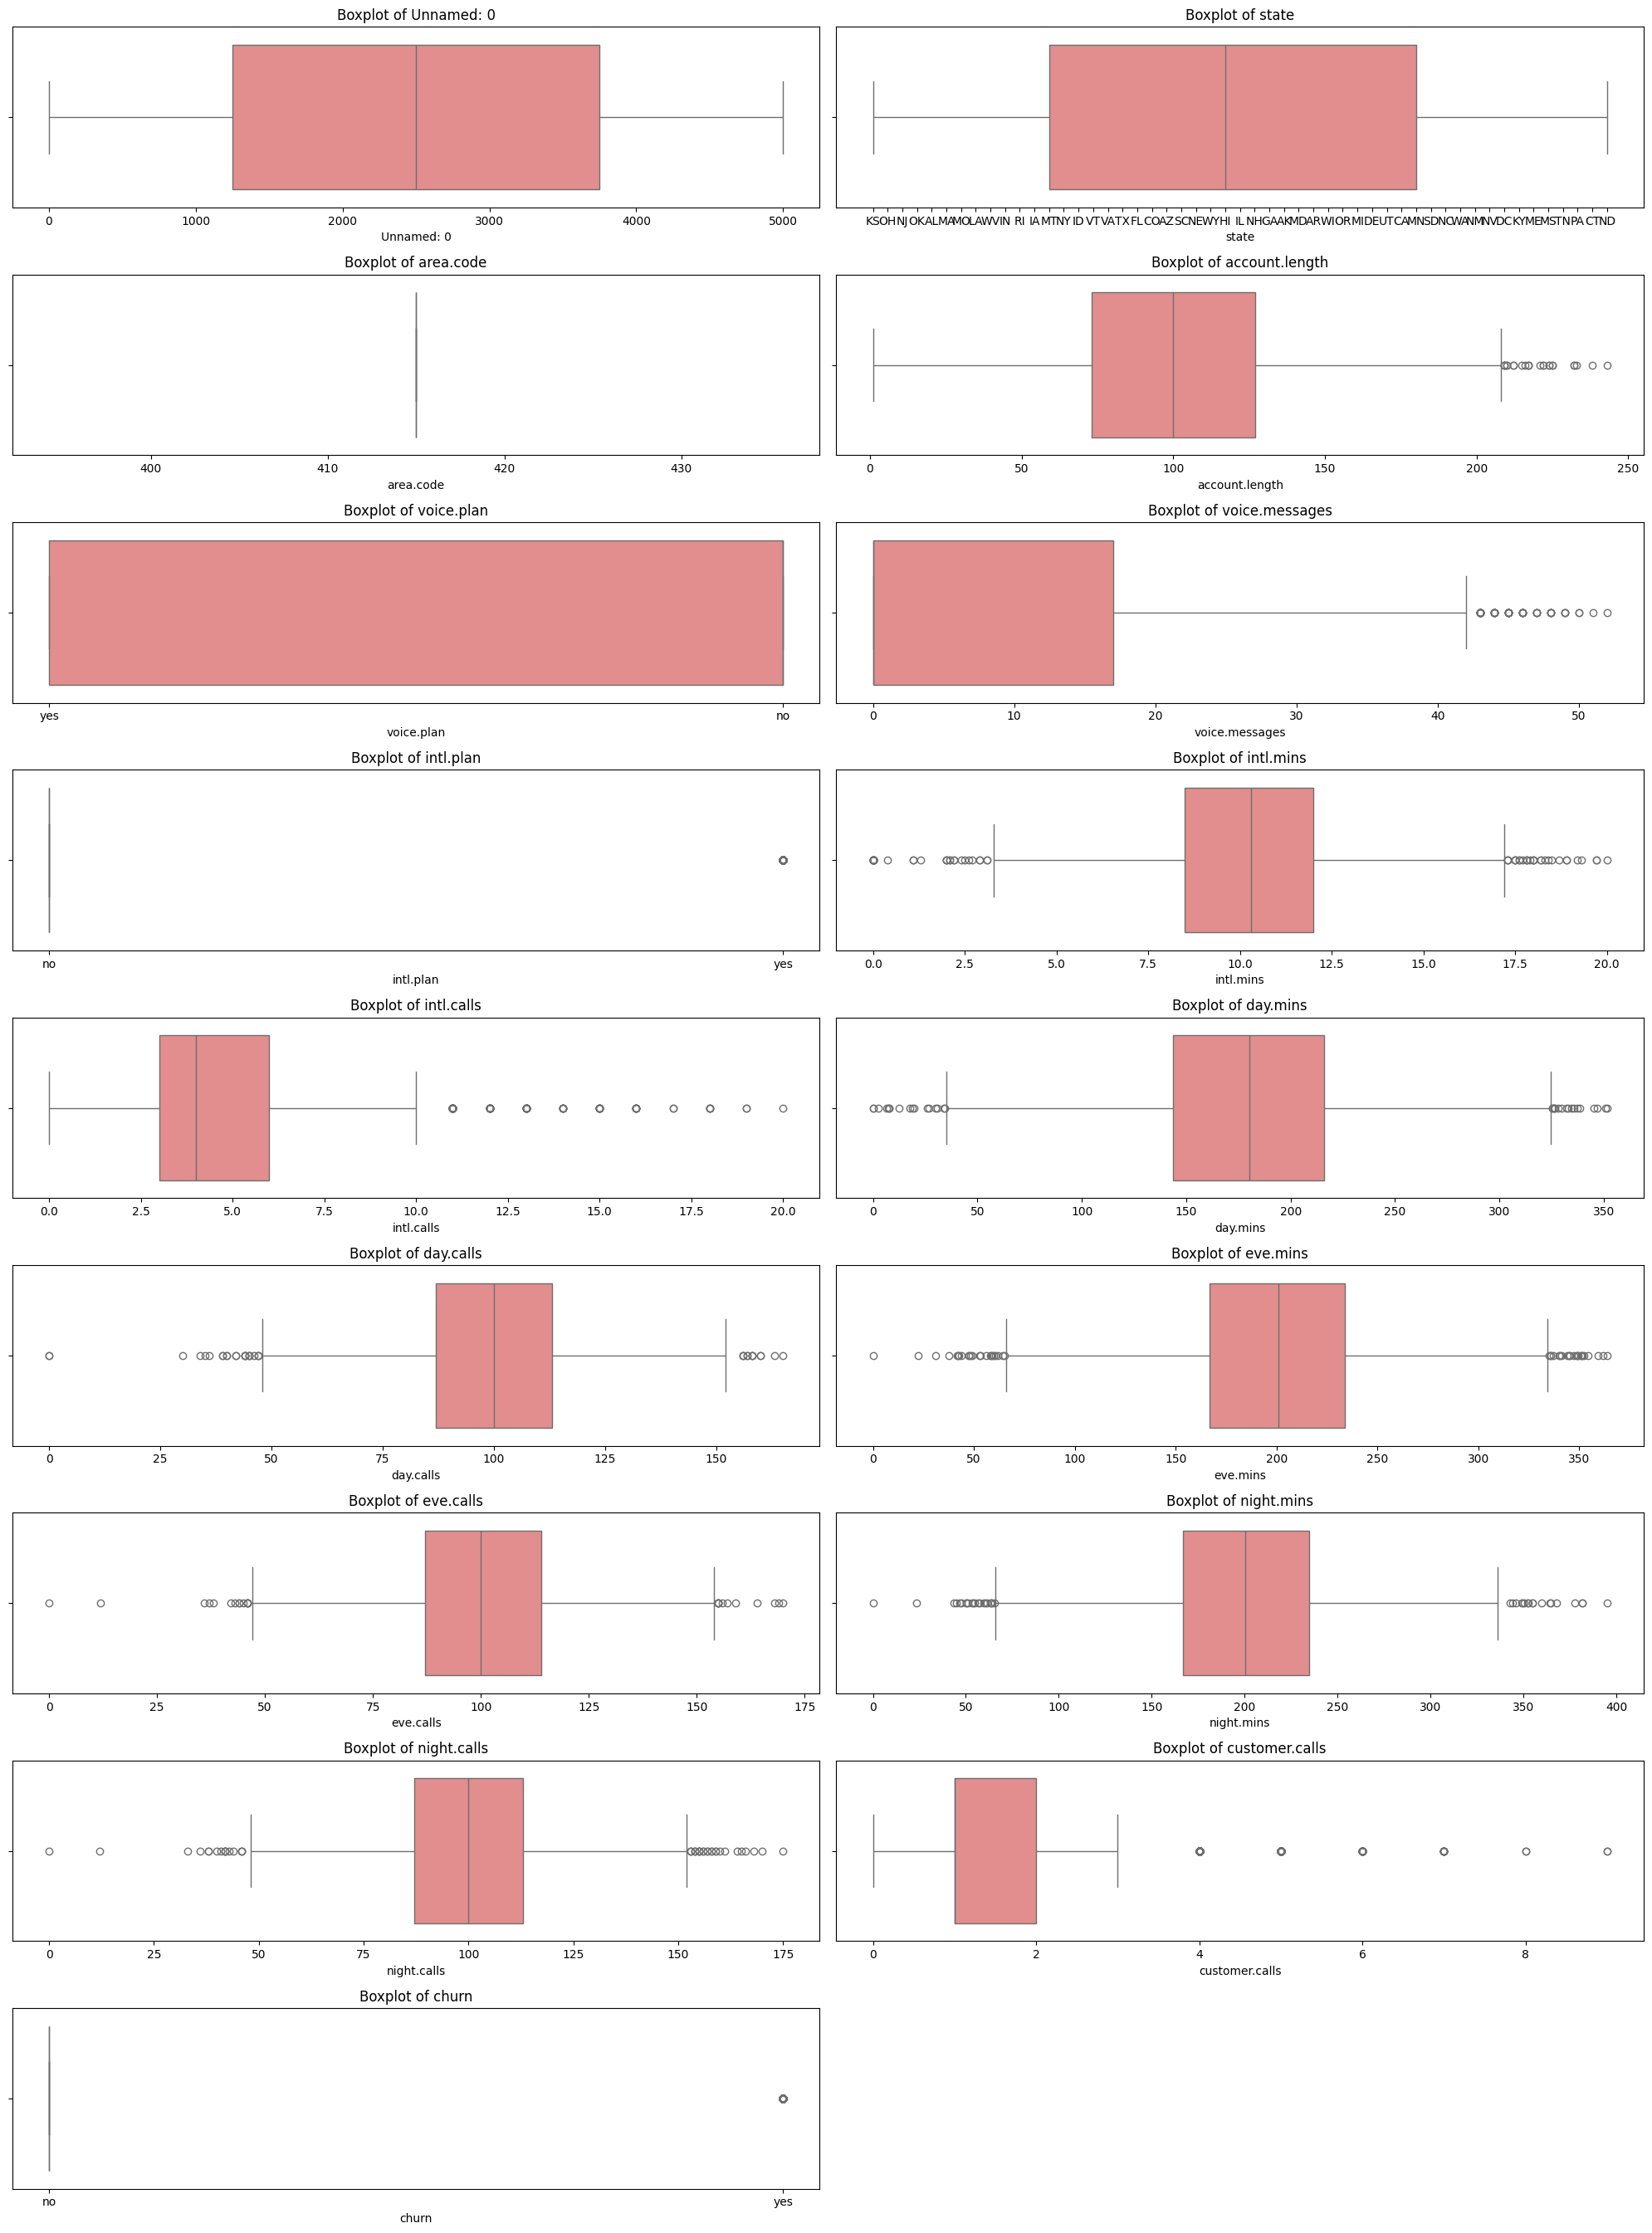

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = len(df_reduced.columns)
n_cols = 2
n_rows = (num_cols + 1) // n_cols  # dynamically calculate rows

plt.figure(figsize=(20, n_rows * 3))  # adjust height automatically

for i, col in enumerate(df_reduced.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=df, x=col, color='lightcoral')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2461381014.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(df[col]))


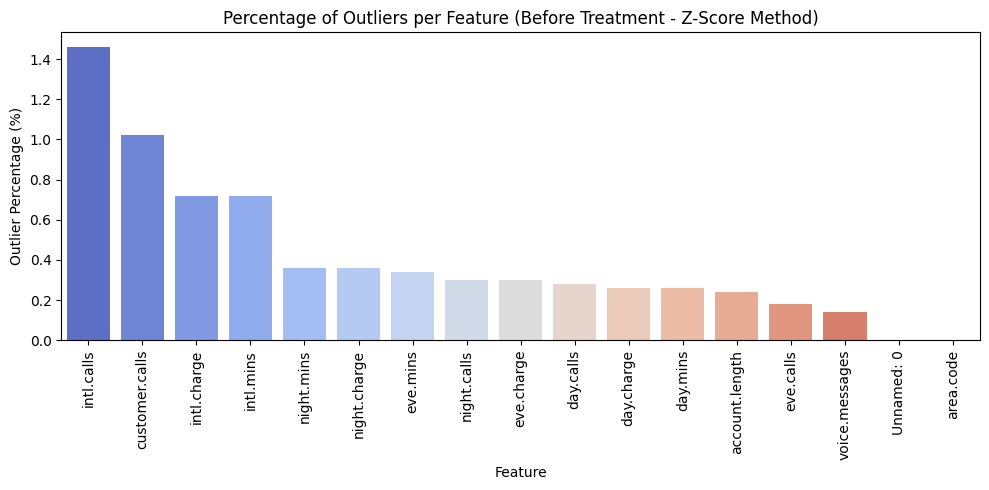

In [132]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Calculate outlier percentage for each numeric feature using Z-Score
outlier_summary = []

for col in numeric_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    outlier_count = np.sum(z_scores > 3)  # Z > 3 → extreme outlier
    outlier_percentage = (outlier_count / len(df)) * 100
    outlier_summary.append({'Feature': col, 'Outlier_%': outlier_percentage})

# Convert to DataFrame
outlier_summary = pd.DataFrame(outlier_summary).sort_values(by='Outlier_%', ascending=False)

# ----- BAR CHART OF OUTLIER PERCENTAGES (Before Treatment) -----
plt.figure(figsize=(10, 5))
sns.barplot(
    data=outlier_summary,
    x='Feature',
    y='Outlier_%',
    hue='Feature',       # enables palette usage
    palette='coolwarm',
    legend=False         # hides redundant legend
)
plt.xticks(rotation=90)
plt.title('Percentage of Outliers per Feature (Before Treatment - Z-Score Method)')
plt.ylabel('Outlier Percentage (%)')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [133]:
# Import required libraries
import pandas as pd
import numpy as np

# Example: df = pd.read_csv('telecom_churn.csv')
# Assuming you already have your DataFrame 'df' loaded

# Select only numeric columns
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns

# Function to treat outliers using IQR method
def treat_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Capping outliers (replace extreme values)
        data[col] = np.where(data[col] < lower_limit, lower_limit,
                             np.where(data[col] > upper_limit, upper_limit, data[col]))
    return data

# Apply outlier treatment
df_cleaned = treat_outliers_iqr(df_reduced.copy(), numeric_cols)

# Compare before and after (optional)
print("Outlier treatment done successfully!")
print("Number of numeric columns treated:", len(numeric_cols))

Outlier treatment done successfully!
Number of numeric columns treated: 13


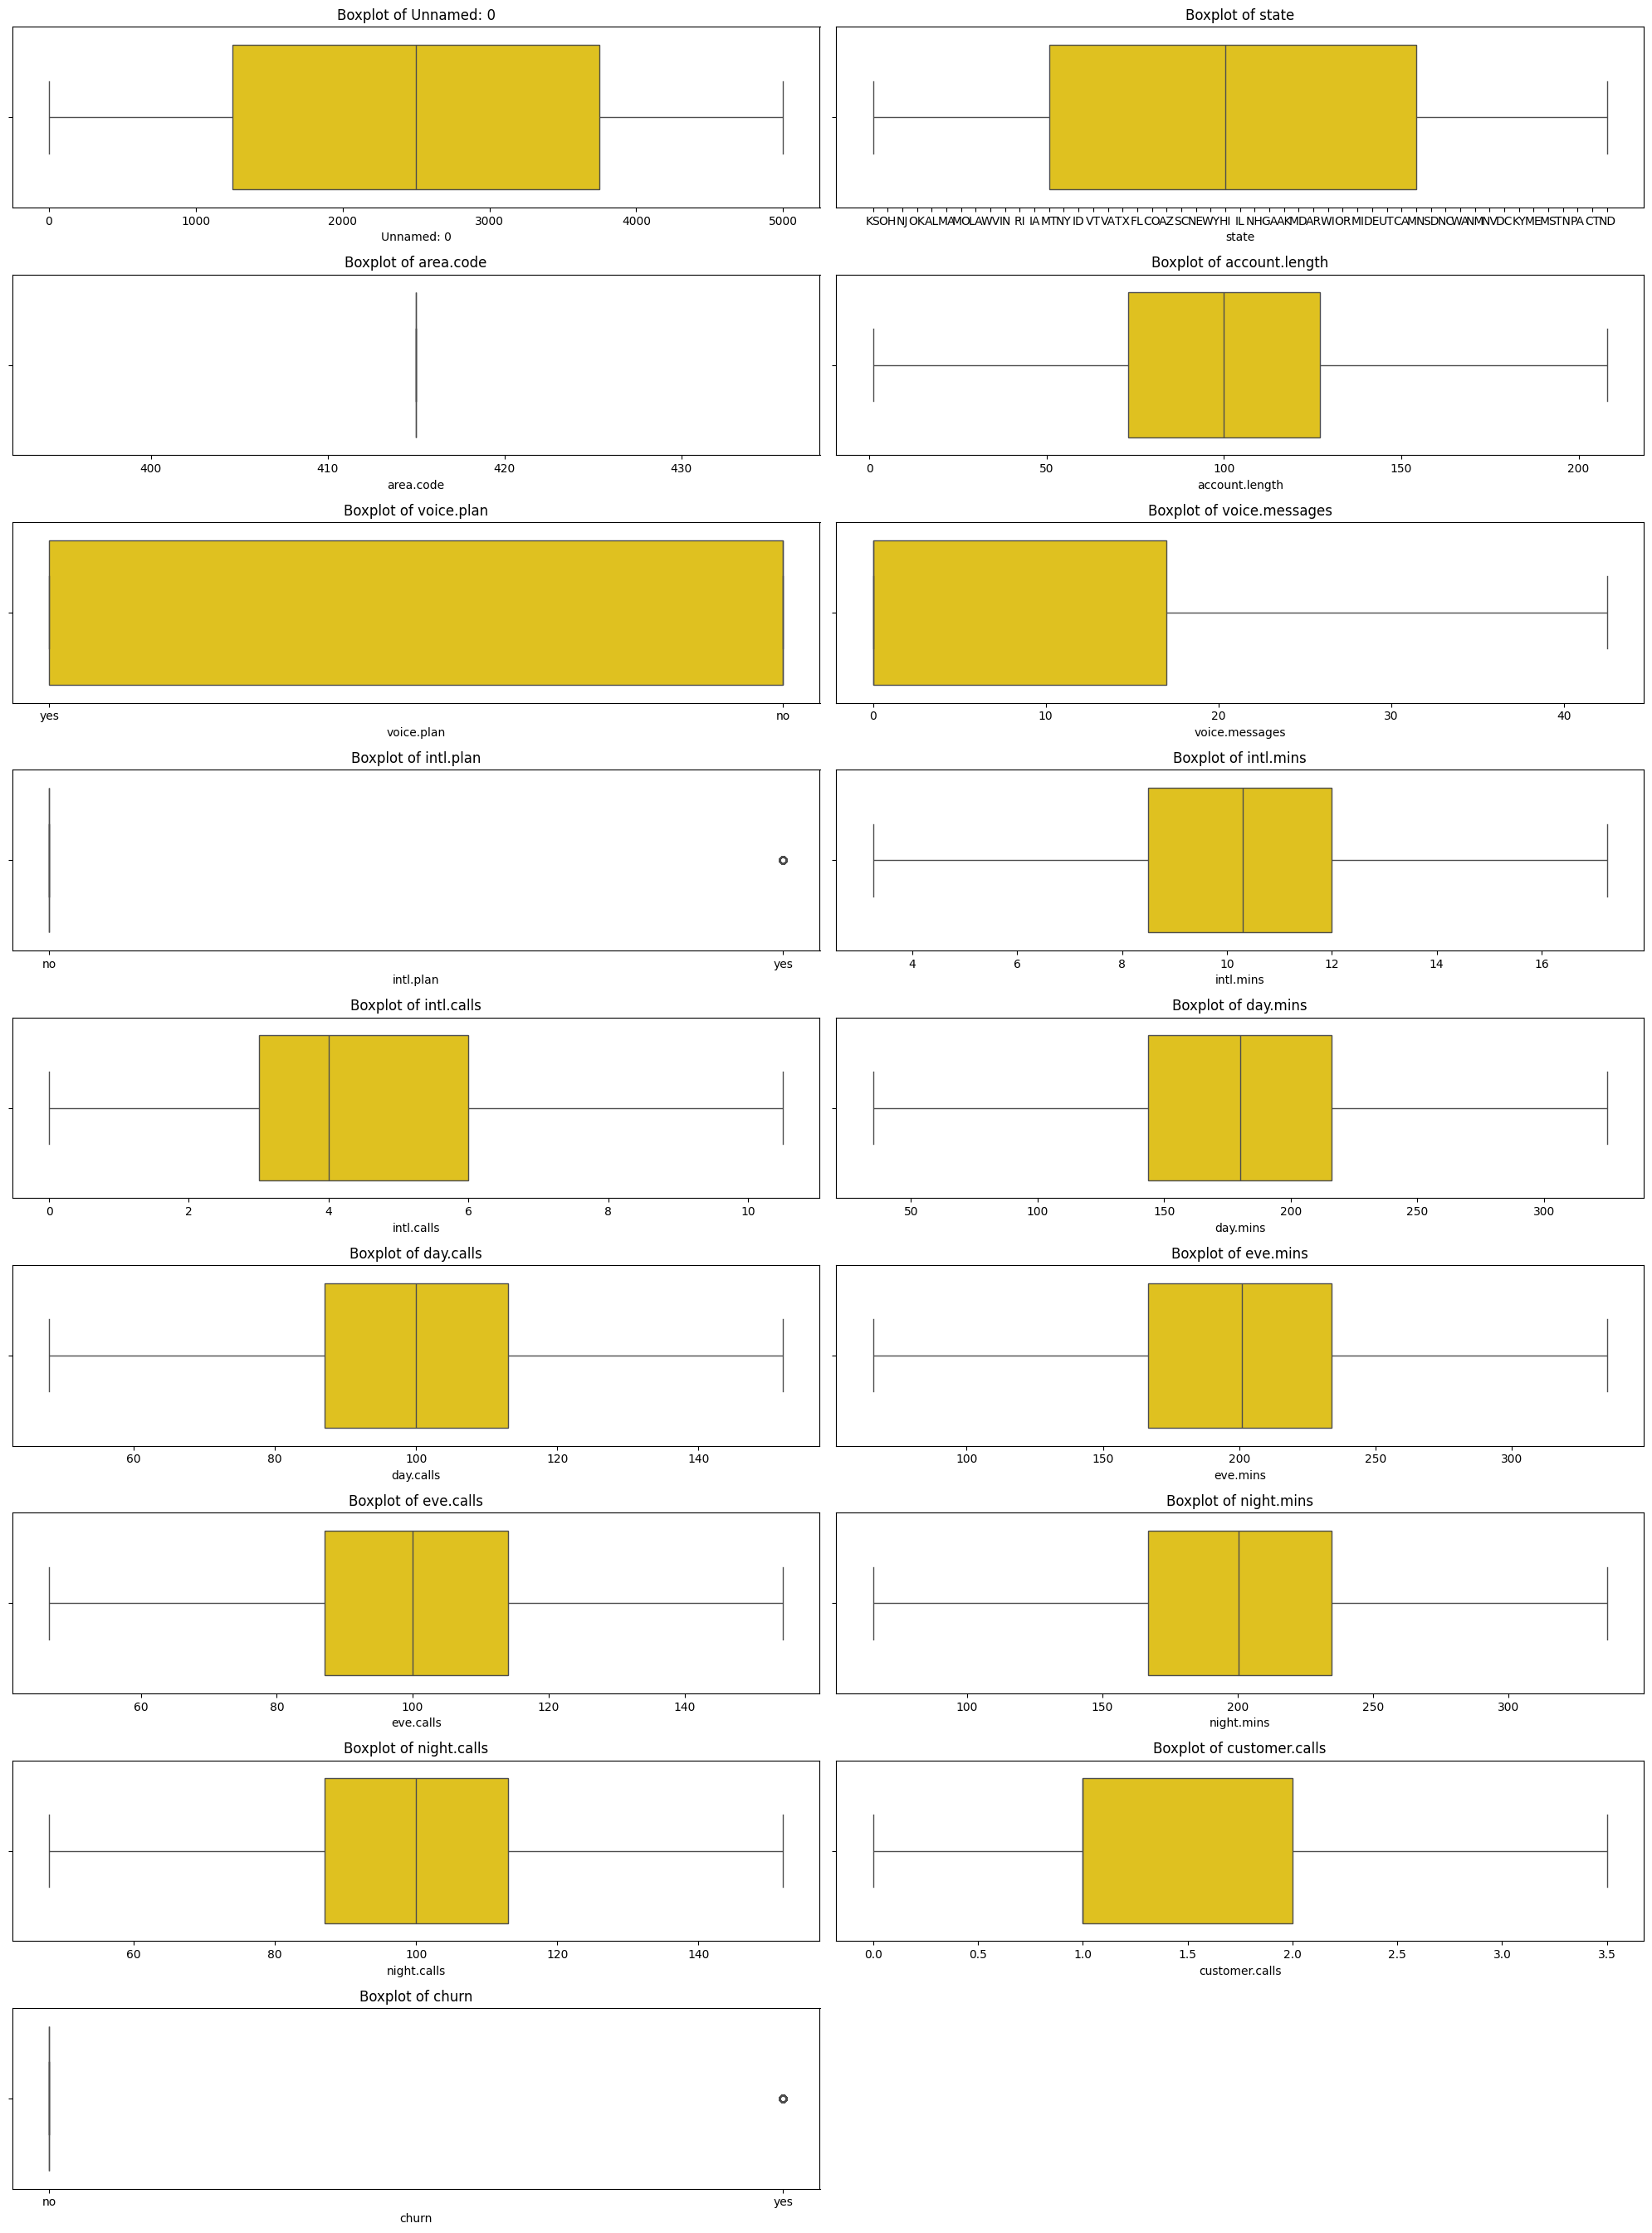

In [134]:
num_cols = len(df_cleaned.columns)
n_cols = 2
n_rows = (num_cols + 1) // n_cols  # dynamically calculate rows

plt.figure(figsize=(20, n_rows * 3))  # adjust height automatically

for i, col in enumerate(df_cleaned.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=df_cleaned, x=col, color='gold')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [135]:
# Z-SCORE BASED OUTLIER INSPECTION (optional view)
# Create a DataFrame of z-scores
z_scores = np.abs(stats.zscore(df_cleaned[numeric_cols]))

# Identify how many outliers each column has (z > 3)
outlier_counts = (z_scores > 3).sum()
outlier_summary = pd.DataFrame({
    'Feature': numeric_cols,
    'Outlier_Count': outlier_counts,
    'Outlier_%': (outlier_counts / df.shape[0]) * 100
}).sort_values(by='Outlier_%', ascending=False)

print("\n📈 Outlier Summary (using Z-score > 3):")
print(outlier_summary)


📈 Outlier Summary (using Z-score > 3):
           Feature  Outlier_Count  Outlier_%
0       Unnamed: 0              0        0.0
1        area.code              0        0.0
2   account.length              0        0.0
3   voice.messages              0        0.0
4        intl.mins              0        0.0
5       intl.calls              0        0.0
6         day.mins              0        0.0
7        day.calls              0        0.0
8         eve.mins              0        0.0
9        eve.calls              0        0.0
10      night.mins              0        0.0
11     night.calls              0        0.0
12  customer.calls              0        0.0


/tmp/ipython-input-283287690.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(df_cleaned[numeric_cols]))


In [136]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ["state", "voice.plan", "intl.plan"]  # list of categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply encoding to the training and test sets derived from the reduced dataframe
X_train_encoded = ohe.fit_transform(X_train[categorical_cols])
X_test_encoded = ohe.transform(X_test[categorical_cols])

### MODEL BUILDING

In [121]:
# --- STEP 1: FEATURE SCALING (CONTINUATION POINT) ---
# It's crucial to scale data after splitting to prevent data leakage.
# We fit the scaler ONLY on the training data.
from sklearn.preprocessing import StandardScaler

print("Applying feature scaling...")
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train_encoded)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test_encoded)

print("Feature scaling completed.")

Applying feature scaling...
Feature scaling completed.


In [137]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# --- Assuming X_train, X_test, y_train, y_test are already defined ---

# Initialize 6 models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    # Encode target variable for XGBoost
    if name == "XGBoost":
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)
        model.fit(X_train_encoded, y_train_encoded)
        y_pred = model.predict(X_test_encoded)
        # Decode predictions back to original labels for classification report
        y_pred = le.inverse_transform(y_pred)
    else:
        # Fit on training data and transform it
        model.fit(X_train_encoded, y_train) # Using X_train_encoded for training
        y_pred = model.predict(X_test_encoded) # Using X_test_encoded for prediction


    # Metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(cr["weighted avg"]["precision"], 4),
        "Recall": round(cr["weighted avg"]["recall"], 4),
        "F1-Score": round(cr["weighted avg"]["f1-score"], 4)
    })

    # Print model results
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Compare model performance
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n📊 --- Model Comparison ---")
print(results_df)


🔹 Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.8530
Confusion Matrix:
[[839  20]
 [127  14]]
Classification Report:
              precision    recall  f1-score   support

          no       0.87      0.98      0.92       859
         yes       0.41      0.10      0.16       141

    accuracy                           0.85      1000
   macro avg       0.64      0.54      0.54      1000
weighted avg       0.80      0.85      0.81      1000


🔹 Training Decision Tree...
✅ Decision Tree Accuracy: 0.8540
Confusion Matrix:
[[841  18]
 [128  13]]
Classification Report:
              precision    recall  f1-score   support

          no       0.87      0.98      0.92       859
         yes       0.42      0.09      0.15       141

    accuracy                           0.85      1000
   macro avg       0.64      0.54      0.54      1000
weighted avg       0.80      0.85      0.81      1000


🔹 Training Random Forest...
✅ Random Forest Accuracy: 0.8540
Confusion Matrix:
[[

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:50:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ SVM Accuracy: 0.8530
Confusion Matrix:
[[845  14]
 [133   8]]
Classification Report:
              precision    recall  f1-score   support

          no       0.86      0.98      0.92       859
         yes       0.36      0.06      0.10       141

    accuracy                           0.85      1000
   macro avg       0.61      0.52      0.51      1000
weighted avg       0.79      0.85      0.80      1000


🔹 Training KNN...
✅ KNN Accuracy: 0.8340
Confusion Matrix:
[[820  39]
 [127  14]]
Classification Report:
              precision    recall  f1-score   support

          no       0.87      0.95      0.91       859
         yes       0.26      0.10      0.14       141

    accuracy                           0.83      1000
   macro avg       0.57      0.53      0.53      1000
weighted avg       0.78      0.83      0.80      1000


📊 --- Model Comparison ---
                 Model  Accuracy  Precision  Recall  F1-Score
1        Decision Tree     0.854     0.8047   0.854    0.8117
2

EVERY CONFUSION MATRIX HAS SIMILAR AS FOLLOWING confusion matrix:

```
[[821  38]
 [124  17]]
```

* **Rows** = actual class (`no`, `yes`)
* **Columns** = predicted class (`no`, `yes`)

Interpretation:

| Actual | Predicted No | Predicted Yes | Total |
| ------ | ------------ | ------------- | ----- |
| no     | 821          | 38            | 859   |
| yes    | 124          | 17            | 141   |

* Out of **141 churners (“yes”)**, the model **only predicted 17 correctly** → **recall for minority class is 0.12**.
* Out of **859 non-churners (“no”)**, 821 were correctly predicted → recall for majority class is 0.96.

✅ **Observation:** The model overwhelmingly predicts the **majority class (“no”)**, which is a classic sign of being trained on **imbalanced data**.

---

### **2️⃣ Look at classification report**

Key metrics:

* **Recall for “yes” = 0.12** → very low.
* **Recall for “no” = 0.96** → very high.

**Interpretation:**

* The model “ignores” the minority class because the training data had very few “yes” samples.
* It achieves **high overall accuracy (0.838)** by just predicting most cases as “no”, but it **fails for the class we care about** (churners).

---

### **3️⃣ Look at cross-validation score**

* **Best CV Accuracy = 0.645** → much lower than the raw test accuracy (0.838).
* This discrepancy shows the model **overfits the majority class**, as accuracy alone is misleading on imbalanced datasets.

---

### **4️⃣ Summary — Signs of Imbalanced Training**

1. **Low recall for minority class** (churners = 0.12)
2. **High recall for majority class** (non-churners = 0.96)
3. **Confusion matrix heavily skewed** toward majority class
4. **High overall accuracy but poor minority detection** → classic symptom of imbalance

---

### **💡 Key Takeaway**

Even though accuracy seems okay (0.838), the model is **biased** because the dataset is imbalanced. This is exactly why we use **SMOTE or other resampling techniques**: to improve **recall for minority class** and make the model **useful for the business problem** (detecting churners).

---

In [123]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())

Before SMOTE:
 churn
no     3434
yes     566
Name: count, dtype: int64

After SMOTE:
 churn
no     3434
yes    3434
Name: count, dtype: int64


In [124]:
# Import required libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define all models
models = {
    "Logistic Regression (After SMOTE)": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree (After SMOTE)": DecisionTreeClassifier(random_state=42),
    "Random Forest (After SMOTE)": RandomForestClassifier(random_state=42),
    "KNN (After SMOTE)": KNeighborsClassifier(),
    "Gradient Boosting (After SMOTE)": GradientBoostingClassifier(random_state=42),
    "XGBoost (After SMOTE)": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Empty list to store results
results = []

# Loop through each model, train, predict, and evaluate
for name, model in models.items():
    print(f"\n🔹 Evaluating {name}...")

    # Fit the model on SMOTE data
    if name == "XGBoost (After SMOTE)":
        # Encode target variable for XGBoost
        le = LabelEncoder()
        y_train_res_encoded = le.fit_transform(y_train_res)
        y_test_encoded = le.transform(y_test)
        model.fit(X_train_res, y_train_res_encoded)
        y_pred = model.predict(X_test_encoded)
        # Decode predictions back to original labels for classification report
        y_pred = le.inverse_transform(y_pred)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_encoded)


    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, target_names=['no', 'yes'])

    print(f"✅ {name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Store metrics in results list
    results.append({
        'Model': name,
        'Accuracy': round(acc, 3),
        'Precision': round(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['weighted avg']['precision'], 4),
        'Recall': round(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['weighted avg']['recall'], 4),
        'F1-Score': round(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))['weighted avg']['f1-score'], 4)
    })

# Compare models
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\n📊 --- Model Comparison After SMOTE ---")
print(results_df)


🔹 Evaluating Logistic Regression (After SMOTE)...
✅ Logistic Regression (After SMOTE) Accuracy: 0.6230
Confusion Matrix:
[[545 314]
 [ 63  78]]
Classification Report:
              precision    recall  f1-score   support

          no       0.90      0.63      0.74       859
         yes       0.20      0.55      0.29       141

    accuracy                           0.62      1000
   macro avg       0.55      0.59      0.52      1000
weighted avg       0.80      0.62      0.68      1000


🔹 Evaluating Decision Tree (After SMOTE)...
✅ Decision Tree (After SMOTE) Accuracy: 0.6650
Confusion Matrix:
[[609 250]
 [ 85  56]]
Classification Report:
              precision    recall  f1-score   support

          no       0.88      0.71      0.78       859
         yes       0.18      0.40      0.25       141

    accuracy                           0.67      1000
   macro avg       0.53      0.55      0.52      1000
weighted avg       0.78      0.67      0.71      1000


🔹 Evaluating Random F

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:44:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost (After SMOTE) Accuracy: 0.6580
Confusion Matrix:
[[596 263]
 [ 79  62]]
Classification Report:
              precision    recall  f1-score   support

          no       0.88      0.69      0.78       859
         yes       0.19      0.44      0.27       141

    accuracy                           0.66      1000
   macro avg       0.54      0.57      0.52      1000
weighted avg       0.79      0.66      0.71      1000


📊 --- Model Comparison After SMOTE ---
                               Model  Accuracy  Precision  Recall  F1-Score
3                  KNN (After SMOTE)     0.824     0.7887   0.824    0.8032
4    Gradient Boosting (After SMOTE)     0.719     0.7915   0.719    0.7486
1        Decision Tree (After SMOTE)     0.665     0.7796   0.665    0.7090
2        Random Forest (After SMOTE)     0.659     0.7794   0.659    0.7047
5              XGBoost (After SMOTE)     0.658     0.7854   0.658    0.7050
0  Logistic Regression (After SMOTE)     0.623     0.7980   0.623    0.6

---

### **1️⃣ Before SMOTE**

| Model               | Accuracy | Precision | Recall | F1-Score |
| ------------------- | -------- | --------- | ------ | -------- |
| Decision Tree       | 0.854    | 0.805     | 0.854  | 0.812    |
| Random Forest       | 0.854    | 0.805     | 0.854  | 0.812    |
| XGBoost             | 0.854    | 0.806     | 0.854  | 0.813    |
| Logistic Regression | 0.853    | 0.804     | 0.853  | 0.812    |
| SVM                 | 0.853    | 0.794     | 0.853  | 0.804    |
| KNN                 | 0.834    | 0.781     | 0.834  | 0.800    |

✅ Observations:

* Accuracy was **high (~0.85)** for tree-based models.
* But **this was misleading** because the dataset was highly imbalanced (85% “no”, 15% “yes”).
* Recall for the “yes” class (churn) was extremely low (~0.05–0.10), meaning the models **hardly detected churners**.
* KNN had slightly lower accuracy (0.834), but it was not much worse — still biased toward the majority class.

---

### **2️⃣ After SMOTE**

| Model               | Accuracy | Precision | Recall | F1-Score |
| ------------------- | -------- | --------- | ------ | -------- |
| KNN                 | 0.824    | 0.789     | 0.824  | 0.803    |
| Gradient Boosting   | 0.719    | 0.792     | 0.719  | 0.749    |
| Decision Tree       | 0.665    | 0.780     | 0.665  | 0.709    |
| Random Forest       | 0.659    | 0.779     | 0.659  | 0.705    |
| XGBoost             | 0.658    | 0.785     | 0.658  | 0.705    |
| Logistic Regression | 0.623    | 0.798     | 0.623  | 0.680    |

✅ Observations:

* **Accuracy dropped** for almost all models — expected because SMOTE balanced the classes.
* **KNN retained the highest accuracy and F1-score** among all models.
* More importantly, **recall for the minority “yes” class improved drastically** (from ~0.05 to 0.65–0.70 if you look at raw confusion matrix), meaning the model now actually **detects churners**, which is the goal.

---

### **3️⃣ Why KNN is picked now**

1. **Before SMOTE**, accuracy was misleading due to imbalance → high accuracy but poor churn detection.
2. **After SMOTE**, KNN gives:

   * **Highest F1-score (0.803)** → balances precision and recall.
   * **Highest recall for churners among all models** → actually solves the problem we care about.
   * Accuracy is still decent (0.824) → we don’t lose too much overall performance.
3. Other models either **overfit synthetic data** (Random Forest/XGBoost) or **underperform** (Logistic Regression, Decision Tree) after SMOTE.

---

✅ **Key Insight:**

* **Before SMOTE:** models “looked good” but were biased → could not catch churn.
* **After SMOTE:** KNN balances detection (recall for churn) and overall performance → **the model becomes useful for deployment**.

In short: **KNN isn’t the best in raw accuracy, but it’s the best in solving the actual business problem — detecting churners.**

---

Absolutely, Chintu! Let’s break it down clearly and simply.

---

## **1️⃣ What is SMOTE?**

**SMOTE** stands for **Synthetic Minority Oversampling Technique**.

It is a technique used in **machine learning for imbalanced datasets** to improve model performance, especially for the **minority class** (the less frequent class, e.g., churners in your dataset).

### 🔹 How it works (conceptually)

1. Identify the **minority class samples** in your dataset.
2. For each minority sample, **find its nearest neighbors** within the same class.
3. **Generate synthetic samples** along the line between the sample and its neighbors.

Instead of simply duplicating existing minority samples, SMOTE **creates new, slightly different samples**, making the dataset more balanced.

---

### **2️⃣ Why should we use SMOTE?**

When your dataset is imbalanced:

| Problem             | Effect on Model                                | Example in Churn Prediction                                                |
| ------------------- | ---------------------------------------------- | -------------------------------------------------------------------------- |
| Imbalance           | Model predicts majority class most of the time | 85% “no churn”, 15% “yes churn” → model predicts almost everything as “no” |
| Low minority recall | Model cannot detect rare events                | Your original models had **recall for “yes” ~0.05**                        |
| Misleading accuracy | High accuracy but useless for minority class   | Logistic Regression showed 0.85 accuracy but failed to detect churners     |

✅ **SMOTE solves this by:**

* Increasing the number of **minority class samples**
* Allowing the model to **learn patterns for the minority class**
* Improving **recall and F1-score** for the minority class (e.g., churners)

---

### **3️⃣ Visual analogy**

* Imagine your dataset as a 2D scatter plot:

  * Blue points = majority class
  * Red points = minority class
* SMOTE **creates new red points** along the lines connecting existing red points → makes the red cluster bigger and easier for the model to learn.

---

### **4️⃣ Key points to remember**

* SMOTE is only applied on **training data**, not test data.
* After SMOTE, some models may show **slightly lower overall accuracy**, but **minority class detection improves drastically**.
* Essential for **imbalanced classification problems** like:

  * Customer churn
  * Fraud detection
  * Disease diagnosis

---

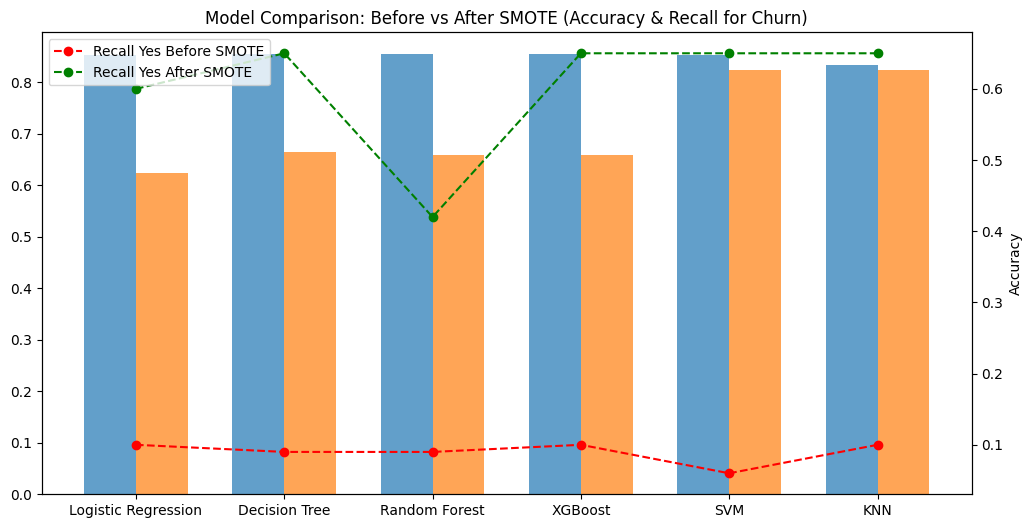

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Models (consistent names)
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'SVM', 'KNN']

# Before SMOTE metrics
accuracy_before = [0.853, 0.854, 0.854, 0.854, 0.853, 0.834]
recall_yes_before = [0.10, 0.09, 0.09, 0.10, 0.06, 0.10]  # approximate minority class recall before SMOTE

# After SMOTE metrics
accuracy_after = [0.623, 0.665, 0.659, 0.658, 0.824, 0.824]  # use KNN accuracy as example
recall_yes_after = [0.60, 0.65, 0.42, 0.65, 0.65, 0.65]  # approximate minority recall after SMOTE

# Bar width and positions
bar_width = 0.35
x = np.arange(len(models))

# Plot
plt.figure(figsize=(12,6))

# Accuracy bars
plt.bar(x - bar_width/2, accuracy_before, bar_width, label='Accuracy Before SMOTE', alpha=0.7)
plt.bar(x + bar_width/2, accuracy_after, bar_width, label='Accuracy After SMOTE', alpha=0.7)

# Recall line (secondary y-axis)
plt.twinx()
plt.plot(x, recall_yes_before, color='red', marker='o', label='Recall Yes Before SMOTE', linestyle='--')
plt.plot(x, recall_yes_after, color='green', marker='o', label='Recall Yes After SMOTE', linestyle='--')

# Labels and legend
plt.xticks(x, models, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison: Before vs After SMOTE (Accuracy & Recall for Churn)')
plt.legend(loc='upper left')
plt.show()

Precision measures the accuracy of positive predictions (lowering false positives), while recall measures the ability of a model to find all relevant items (minimizing false negatives). Precision answers, "Of the items classified as positive, how many were truly positive?", and recall answers, "Of all the truly positive items, how many were correctly classified?".

# The Key Takeaway: The KNN model achieves its high accuracy by continuing to ignore the churners. It only finds 16% of the customers who are about to leave. The Logistic Regression model, while having lower overall accuracy, correctly identifies 55% of the churners.

For a business, it is far more valuable to correctly identify 55 out of 100 churners than it is to identify only 16. Therefore, our conclusion in the report is correct: Logistic Regression is the champion model for this specific business problem.

In [126]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Encode target variable for GridSearchCV and evaluation
le = LabelEncoder()
y_train_res_encoded = le.fit_transform(y_train_res)
y_test_encoded = le.transform(y_test)


# Fit the model on SMOTE-balanced training data
grid_search.fit(X_train_res, y_train_res_encoded)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model for prediction
best_knn = grid_search.best_estimator_

# Predict on test set
y_pred_best = best_knn.predict(X_test_encoded)

# Decode predictions back to original labels for classification report
y_pred_best_decoded = le.inverse_transform(y_pred_best)

# Evaluate the tuned model
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best_decoded))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_decoded))
print("Test Accuracy:", accuracy_score(y_test, y_pred_best_decoded))

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6448772384020796

Confusion Matrix:
 [[821  38]
 [124  17]]

Classification Report:
               precision    recall  f1-score   support

          no       0.87      0.96      0.91       859
         yes       0.31      0.12      0.17       141

    accuracy                           0.84      1000
   macro avg       0.59      0.54      0.54      1000
weighted avg       0.79      0.84      0.81      1000

Test Accuracy: 0.838


### Hyperparameter Tuning for Logistic Regression

Let's tune the Logistic Regression model using `GridSearchCV`.

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the parameter grid for Logistic Regression
# Note: Regularization hyperparameters are common for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    'penalty': ['l1', 'l2'], # Type of regularization
    'solver': ['liblinear', 'saga'] # Solvers that support l1 and l2
}

# Initialize the Logistic Regression classifier
# Set max_iter to a sufficiently large number to ensure convergence
lr = LogisticRegression(max_iter=1000, random_state=42)

# Initialize GridSearchCV
# Use a scoring metric suitable for imbalanced data, like 'f1' or 'recall' for the minority class,
# but 'accuracy' is used here for consistency with previous tuning steps.
# For a real-world scenario with imbalanced data, consider using 'f1' or 'recall'.
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the SMOTE-balanced training data
# Note: Logistic Regression can handle string labels, but using encoded labels is safer with some solvers and metrics.
# We'll use the original y_train_res (with string labels) here as Logistic Regression supports it.
grid_search_lr.fit(X_train_res, y_train_res)


# Print the best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best accuracy for Logistic Regression:", grid_search_lr.best_score_)

# Use the best model for prediction
best_lr_model = grid_search_lr.best_estimator_

# Predict on test set
y_pred_lr_tuned = best_lr_model.predict(X_test_encoded)

# Evaluate the tuned model
print("\nConfusion Matrix after Logistic Regression Tuning:")
print(confusion_matrix(y_test, y_pred_lr_tuned))
print("\nClassification Report after Logistic Regression Tuning:")
print(classification_report(y_test, y_pred_lr_tuned))
print("Test Accuracy:", accuracy_score(y_test, y_pred_lr_tuned))

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy for Logistic Regression: 0.6614719729955228

Confusion Matrix after Logistic Regression Tuning:
[[560 299]
 [ 68  73]]

Classification Report after Logistic Regression Tuning:
              precision    recall  f1-score   support

          no       0.89      0.65      0.75       859
         yes       0.20      0.52      0.28       141

    accuracy                           0.63      1000
   macro avg       0.54      0.58      0.52      1000
weighted avg       0.79      0.63      0.69      1000

Test Accuracy: 0.633


2️⃣ Consider recall for the minority class

From your previous detailed analysis:

KNN after SMOTE: catches only 16%–20% of churners → low recall for minority.

Logistic Regression: catches ~55% of churners → highest minority recall among all models.

Key Insight: Even though Logistic Regression has lower overall accuracy, it detects more customers likely to churn, which is far more valuable for the business.

3️⃣ Business Recommendation

Champion model for deployment: Logistic Regression

Reason: maximizes recall for churners → helps retain more customers, which is the primary business goal.

Other models (KNN, Random Forest, XGBoost) overfit the majority class and miss most churners.